# GAN creation

In [20]:
# For COLAB
from google.colab import drive
drive.mount('/content/gdrive')
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download xhlulu/140k-real-and-fake-faces
! unzip /content/140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [22]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1575018375347691819
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4545197522000949608
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [23]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Physical devices cannot be modified after being initialized


## Dataset loading

In [24]:
from keras.preprocessing.image import ImageDataGenerator

In [25]:
BATCH_SIZE = 64
image_height = 64
image_width = 64
latent_features = 128
num_images = 1000

In [26]:
# Define the input and output directories
input_directory = 'real_vs_fake/real-vs-fake/test/'

# Create a dataset from the images
real_folder = os.path.join(input_directory, 'real')
image_paths = [os.path.join(real_folder, filename) for filename in os.listdir(real_folder)[:num_images]]

# Function to preprocess the image
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [image_height, image_width])
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Create a dataset from the image paths
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)

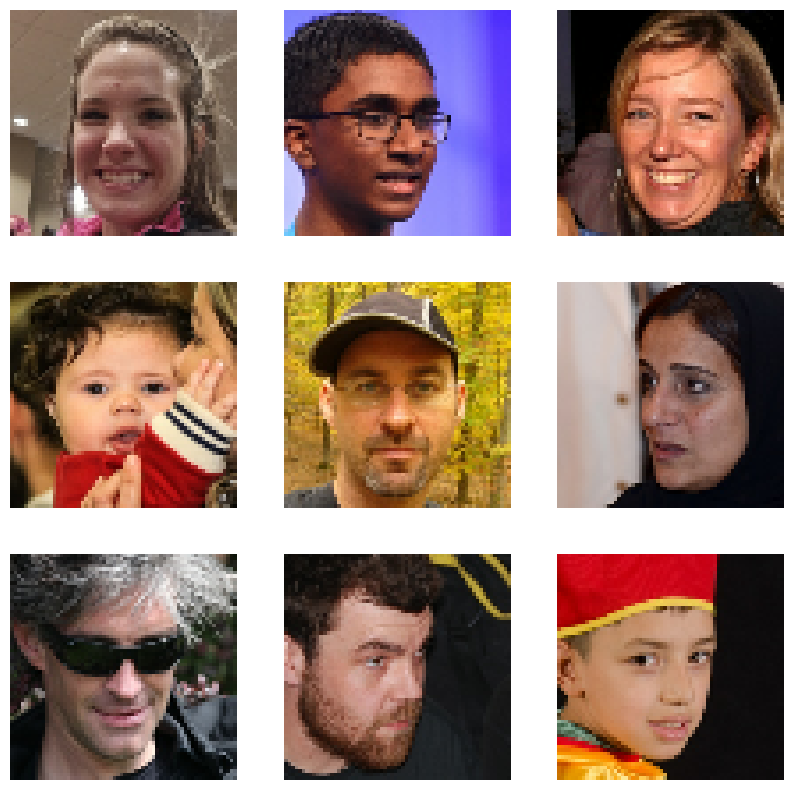

In [27]:
for batch in dataset.take(1):  # Take the first batch for display
    plt.figure(figsize=(10, 10))
    for i in range(min(BATCH_SIZE, 9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy())
        plt.axis("off")
    plt.show()

## GAN architecture

In [98]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, ReLU, Conv2DTranspose, BatchNormalization

In [119]:
def build_generator():
    model = Sequential()

    # Beginnings of a generated image
    model.add(Dense(4*4*1024, input_dim=latent_features))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Reshape((4,4,1024)))

    # Upsampling block
    model.add(Conv2DTranspose(512, (4,4), (2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # Upsampling block
    model.add(Conv2DTranspose(256, (4,4), (2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # Upsampling block
    model.add(Conv2DTranspose(128, (4,4), (2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # Upsampling block
    model.add(Conv2DTranspose(3, (4,4), (2,2),padding='same', activation='tanh'))

    return model

generator = build_generator()
generator.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 16384)             2113536   
                                                                 
 batch_normalization_70 (Ba  (None, 16384)             65536     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_74 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_14 (Reshape)        (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_41 (Conv2  (None, 8, 8, 512)         8389120   
 DTranspose)                                                     
                                                                 
 batch_normalization_71 (Ba  (None, 8, 8, 512)       

1/1 [==============================] - 0s 155ms/step


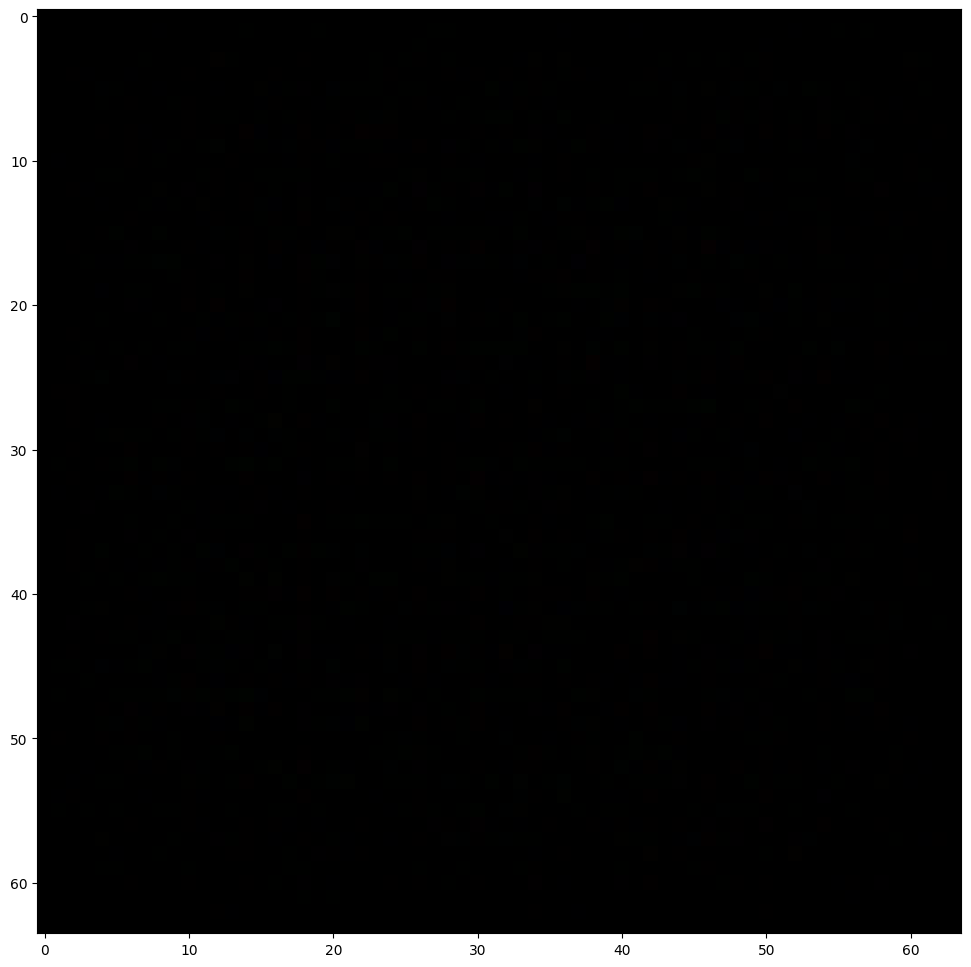

In [100]:
img = generator.predict(np.random.normal(size=(1, latent_features, 1)))
plt.figure(figsize=(16,12))
plt.imshow(img[0])

In [101]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(128, 4, 2, padding='same', input_shape = (image_width,image_height,3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))

    model.add(Conv2D(256, 4, 2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))

    model.add(Conv2D(512, 4, 2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))

    model.add(Conv2D(1024, 4, 2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 32, 32, 128)       6272      
                                                                 
 leaky_re_lu_65 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_54 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 16, 16, 256)       524544    
                                                                 
 batch_normalization_62 (Ba  (None, 16, 16, 256)       1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                     

In [102]:
img = generator.predict(np.random.normal(size=(4, latent_features, 1)))

1/1 [==============================] - 0s 17ms/step


In [103]:
discriminator.predict(img)

1/1 [==============================] - 0s 96ms/step


array([[0.500037  ],
       [0.50002575],
       [0.5000024 ],
       [0.50003886]], dtype=float32)

## Training loop

In [104]:
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.preprocessing.image import array_to_img
from keras.callbacks import Callback

In [105]:
g_opt = Adam(learning_rate=0.0004)
d_opt = Adam(learning_rate=0.0008)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [106]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((BATCH_SIZE, latent_features, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.ones_like(yhat_real), tf.zeros_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = -0.05*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.05*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((BATCH_SIZE,latent_features,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.ones_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [107]:
gan = GAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [108]:
class ModelMonitor(Callback):
    def __init__(self, num_img=1, latent_dim=latent_features):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            os.makedirs("/content/training/", exist_ok=True)
            img.save(os.path.join('images', f'/content/training/{epoch}_generated_img.png'))

## Training

In [113]:
hist = gan.fit(dataset, epochs=100, callbacks=[ModelMonitor()])

Epoch 1/100
 6/16 [==========>...................] - ETA: 3s - d_loss: 0.1250 - g_loss: 0.1601

16/16 [==============================] - 5s 336ms/step - d_loss: 0.1244 - g_loss: 0.1592
Epoch 2/100
16/16 [==============================] - 5s 338ms/step - d_loss: 0.1237 - g_loss: 0.1669
Epoch 3/100
16/16 [==============================] - 5s 326ms/step - d_loss: 0.1238 - g_loss: 0.1670
Epoch 4/100
16/16 [==============================] - 5s 324ms/step - d_loss: 0.1269 - g_loss: 0.2256
Epoch 5/100
16/16 [==============================] - 5s 313ms/step - d_loss: 0.1261 - g_loss: 0.2282
Epoch 6/100
16/16 [==============================] - 5s 311ms/step - d_loss: 0.1243 - g_loss: 0.1875
Epoch 7/100
16/16 [==============================] - 5s 315ms/step - d_loss: 0.1255 - g_loss: 0.1880
Epoch 8/100
16/16 [==============================] - 5s 312ms/step - d_loss: 0.1242 - g_loss: 0.1828
Epoch 9/100
16/16 [==============================] - 5s 316ms/step - d_loss: 0.1215 - g_loss: 0.1968
Epoch 10/100
16/16 [==============================] - 5s 316ms/step - d_loss: 0.1256 - g_loss: 0.2134
E

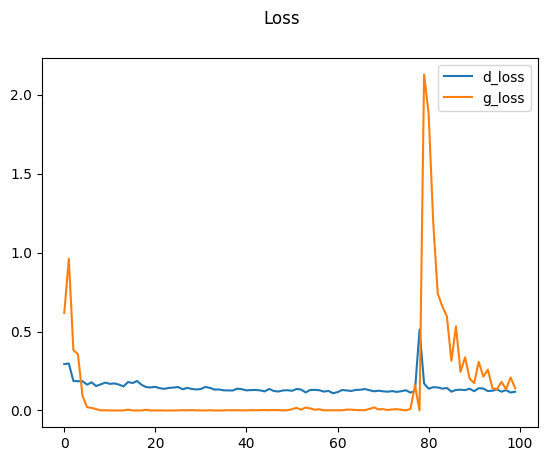

In [110]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

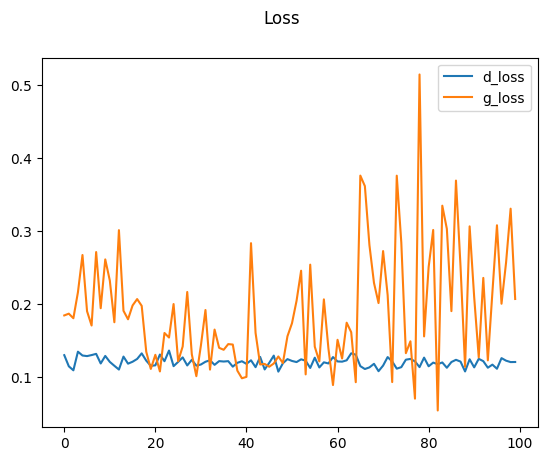

In [114]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [115]:
generator.save('/content/gdrive/MyDrive/GAN_research/generator.h5')
discriminator.save('/content/gdrive/MyDrive/GAN_research/discriminator.h5')

## Testing

1/1 [==============================] - 0s 26ms/step


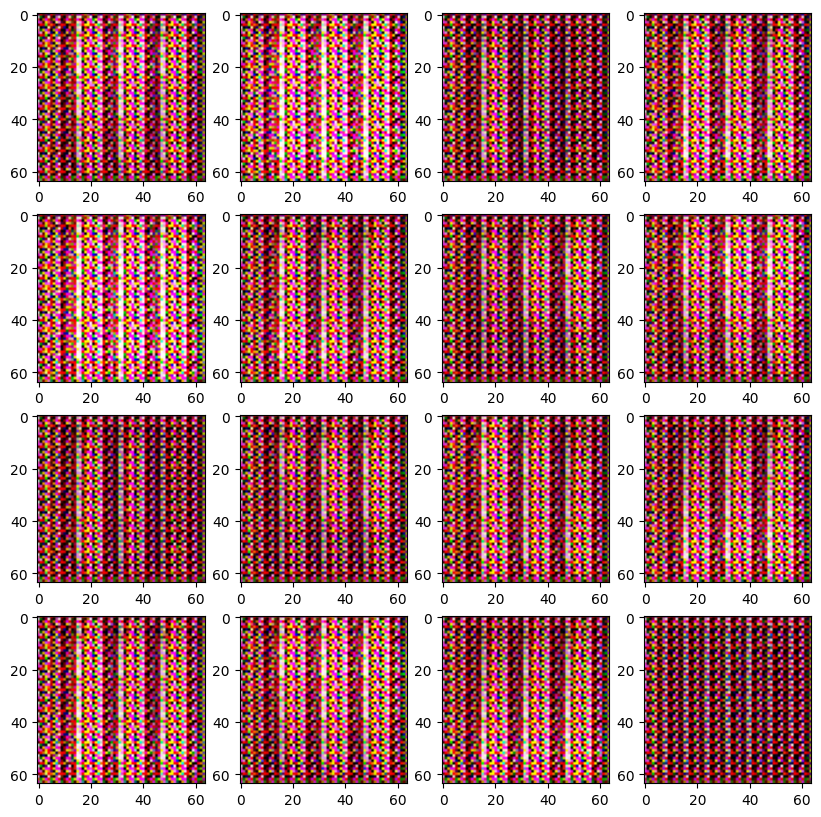

In [116]:
imgs = generator.predict(tf.random.normal((16, latent_features, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])